In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys



import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import the data

In [ ]:

data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
labels = data[:,0]
data = data[:,1:]
#dataNorm = data / np.max(data)
dataNorm = data / np.max(data)
dataNorm = 2*dataNorm - 1


dataT = torch.tensor( dataNorm ).float()
labelsT=torch.tensor( labels ).long()

batchsize = 100

# Create classes for the discriminator and generator

In [ ]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(28*28,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.sigmoid( x )

dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.5045],
        [0.5094],
        [0.5144],
        [0.4918],
        [0.5329],
        [0.5055],
        [0.5055],
        [0.5051],
        [0.5024],
        [0.5372]], grad_fn=<SigmoidBackward0>)

In [ ]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x )




# Train the models!

In [ ]:

lossfun = nn.BCELoss()


dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)


d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [ ]:

num_epochs = 50000

losses  = np.zeros((num_epochs,2))
disDecs = np.zeros((num_epochs,2)) 

for epochi in range(num_epochs):
    

  randidx     = torch.randint(dataT.shape[0],(batchsize,))
  real_images = dataT[randidx,:].to(device)
  fake_images = gnet( torch.randn(batchsize,64).to(device) ) 



  real_labels = torch.ones(batchsize,1).to(device)
  fake_labels = torch.zeros(batchsize,1).to(device)




  pred_real   = dnet(real_images)              
  d_loss_real = lossfun(pred_real,real_labels) 
  

  pred_fake   = dnet(fake_images)
  d_loss_fake = lossfun(pred_fake,fake_labels)
  
 
  d_loss = d_loss_real + d_loss_fake
  losses[epochi,0]  = d_loss.item()
  disDecs[epochi,0] = torch.mean((pred_real>.5).float()).detach()


  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()

  
  

  ### Train the generator 


  fake_images = gnet( torch.randn(batchsize,64).to(device) )
  pred_fake   = dnet(fake_images)
  

  g_loss = lossfun(pred_fake,real_labels)
  losses[epochi,1]  = g_loss.item()
  disDecs[epochi,1] = torch.mean((pred_fake>.5).float()).detach()

  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()


  if (epochi+1)%500==0:
    msg = f'Finished epoch {epochi+1}/{num_epochs}'
    sys.stdout.write('\r' + msg)
  

Finished epoch 50000/50000

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

*italicised text*# Let's see some fake digits!

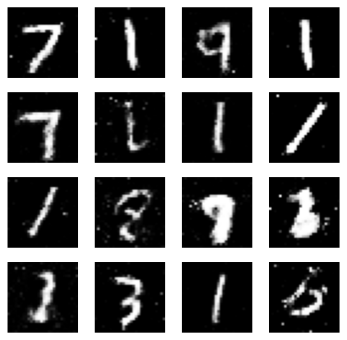

In [ ]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(batchsize,64).to(device)).cpu()


# and visualize...
fig,axs = plt.subplots(4,4,figsize=(6,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:].detach().view(28,28),cmap='gray')
  ax.axis('off')
  #ax.set_title("Label: {}".format(fake_data[i,:,]))

plt.show()

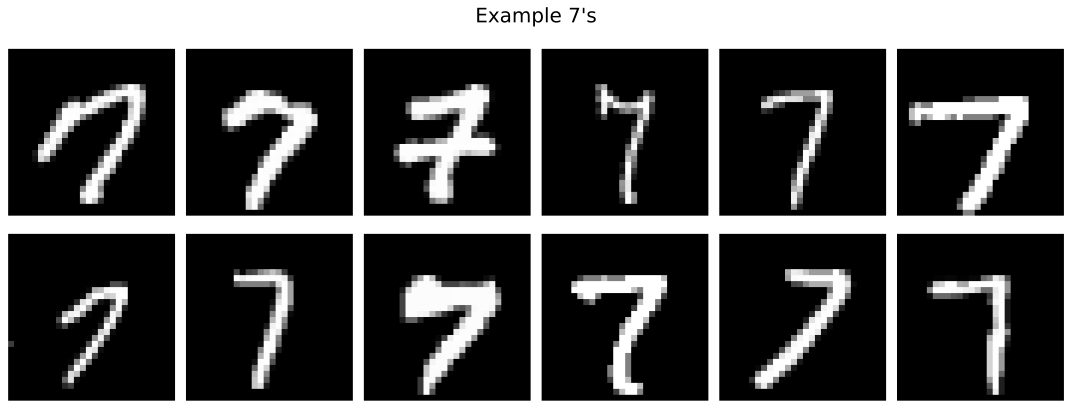

In [ ]:


the7s = np.where(labels==7)[0]

# draw the first 12
fig,axs = plt.subplots(2,6,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):
  img = np.reshape(data[the7s[i],:],(28,28))
  ax.imshow(img,cmap='gray')
  ax.axis('off')

plt.suptitle("Example 7's",fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

In [ ]:
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

In [ ]:


# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NOTE: log-softmax the output (b/c loss function)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()
iterator = iter(train_loader)
X,y = next(iterator)
yHat = net(X)

# confirm really binary
torch.unique(X)

tensor([-1.0000, -0.9922, -0.9843, -0.9765, -0.9686, -0.9608, -0.9529, -0.9451,
        -0.9373, -0.9294, -0.9216, -0.9137, -0.9059, -0.8980, -0.8902, -0.8824,
        -0.8745, -0.8667, -0.8588, -0.8510, -0.8431, -0.8353, -0.8275, -0.8196,
        -0.8118, -0.8039, -0.7961, -0.7882, -0.7804, -0.7725, -0.7647, -0.7569,
        -0.7490, -0.7412, -0.7333, -0.7255, -0.7176, -0.7098, -0.7020, -0.6941,
        -0.6863, -0.6784, -0.6706, -0.6627, -0.6549, -0.6471, -0.6392, -0.6314,
        -0.6235, -0.6157, -0.6078, -0.6000, -0.5922, -0.5843, -0.5765, -0.5686,
        -0.5608, -0.5529, -0.5451, -0.5373, -0.5294, -0.5216, -0.5137, -0.5059,
        -0.4980, -0.4902, -0.4824, -0.4745, -0.4667, -0.4588, -0.4510, -0.4431,
        -0.4353, -0.4275, -0.4196, -0.4118, -0.4039, -0.3961, -0.3882, -0.3804,
        -0.3725, -0.3647, -0.3569, -0.3490, -0.3412, -0.3333, -0.3255, -0.3176,
        -0.3098, -0.3020, -0.2941, -0.2863, -0.2784, -0.2706, -0.2627, -0.2549,
        -0.2471, -0.2392, -0.2314, -0.22

In [ ]:
def funtion2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [ ]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()


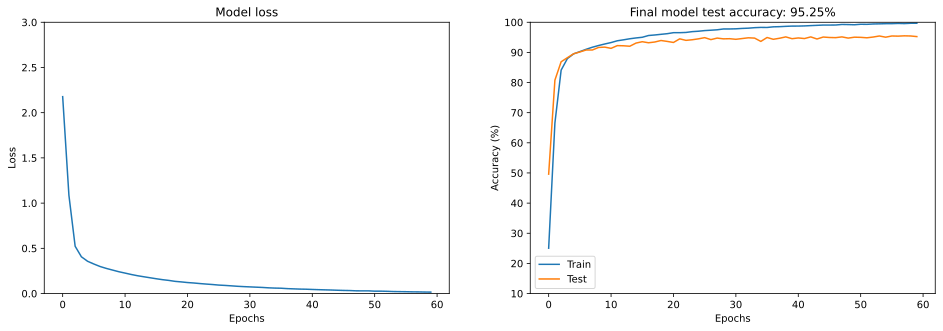

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
fake_dataset = TensorDataset(fake_data)

In [ ]:
fake_loader = DataLoader(fake_dataset,batch_size=batchsize,shuffle=False,drop_last=True)

In [ ]:
X = next(iter(fake_loader))[0] # note: only need one output, hence the [0]
predictions = net(X).detach()

# save the model guesses
guesses = torch.argmax(predictions,axis=1).detach()

In [ ]:
guesses

tensor([7, 1, 9, 1, 7, 1, 1, 1, 1, 8, 7, 2, 3, 3, 1, 6, 1, 1, 9, 1, 1, 8, 9, 1,
        1, 1, 5, 9, 6, 2, 6, 4])

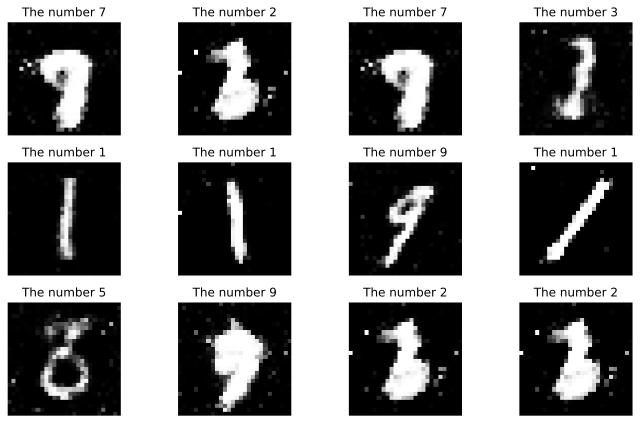

In [ ]:

fig,axs = plt.subplots(3,4,figsize=(10,6))

someRandom7s = np.random.choice(len(X),12)

for i,ax in enumerate(axs.flatten()):

  thisimg = X[ someRandom7s[i] ].detach().view(28,28)
  ax.imshow(thisimg,cmap='gray')
  ax.set_title(f'The number {guesses[ someRandom7s[i] ]}')
  ax.axis('off')

plt.tight_layout()
plt.show()

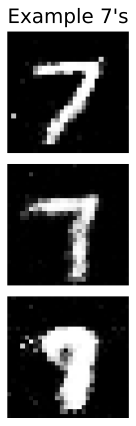

In [ ]:
the7s = np.where(guesses==7)[0]


# draw the first 12
fig,axs = plt.subplots(3,1,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):
  img = np.reshape(X[the7s[i],:].detach(),(28,28))
  ax.imshow(img,cmap='gray')
  ax.axis('off')

plt.suptitle("Example 7's",fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

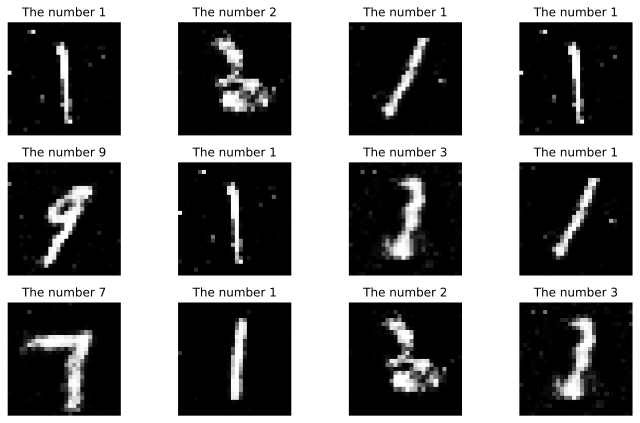

In [ ]:
fig,axs = plt.subplots(3,4,figsize=(10,6))

someRandom7s = np.random.choice(len(X),12)

for i,ax in enumerate(axs.flatten()):

  thisimg = X[ someRandom7s[i] ].detach().view(28,28)
  ax.imshow(thisimg,cmap='gray')
  ax.set_title(f'The number {guesses[ someRandom7s[i] ]}')
  ax.axis('off')

plt.tight_layout()
plt.show()

torch.Size([32, 784])